In [ ]:
import tensorflow as tf
from tensorflow.keras import mixed_precision
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Dense, Dropout, 
                                   BatchNormalization, Input, GlobalAveragePooling2D, 
                                   Concatenate, Multiply, ReLU, Add)
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
import numpy as np
import os
import cv2
import random
import albumentations as A
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from tensorflow.keras.optimizers import AdamW
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import seaborn as sns
import pickle


#*** Model Save is disanbled for testing purposes ***

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices=false'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'  

# === Configuration ===
config = {
    "epochs": 1,
    "is_config_batch_size_param": True,
    "batch_size": 200,
    "initial_lr": 0.001,
    "gpu_memory_limit": 10,
    "target_size": (480, 640),  # 2:3 ratio (width, height)
    "input_shape": (640, 480, 3), # (height, width, channels) for Keras
    "data_path": "Dataset/merged_SMOT_train",
    "csv_path": "processed_data/cleaned_metadata_short.csv",
    "train_set_csv": "Model/training7_resnet18_incept_rgb_Attention_SMOT/training7_resnet18_incept_rgb_Attention_SMOT_train_set.csv",
    "val_set_csv": "Model/training7_resnet18_incept_rgb_Attention_SMOT/training7_resnet18_incept_rgb_Attention_SMOT_validation_set.csv",
    "history_csv": "Model/training7_resnet18_incept_rgb_Attention_SMOT/training7_resnet18_incept_rgb_Attention_SMOT_history.csv",
    "best_model": "Model/training7_resnet18_incept_rgb_Attention_SMOT/training7_resnet18_incept_rgb_Attention_SMOT_best_model.keras",
    "label_encoder_path": "Model/training7_resnet18_incept_rgb_Attention_SMOT/training7_resnet18_incept_rgb_Attention_SMOT_label_encoder.npy",
    "color_channel": ""
}

2025-05-15 00:42:03.030095: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-15 00:42:03.035319: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-15 00:42:03.105469: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-15 00:42:03.131528: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747244523.186799  397072 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747244523.19

In [2]:
# === GPU Setup ===
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        policy = mixed_precision.Policy('float32')
        mixed_precision.set_global_policy(policy)
        
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.optimizer.set_jit(True)
        tf.config.threading.set_intra_op_parallelism_threads(8)
        tf.config.threading.set_inter_op_parallelism_threads(4)
    except RuntimeError as e:
        print(e)

# === Memory Management ===
def calculate_max_batch_size(model, input_shape, gpu_mem=24, default_batch=32, is_use_config_batch_size=config["is_config_batch_size_param"]):
    """Improved batch size calculator with error handling"""
    if is_use_config_batch_size:
        return default_batch
    try:
        params = model.count_params()
        
        last_dense = None
        for layer in reversed(model.layers):
            if isinstance(layer, tf.keras.layers.Dense):
                last_dense = layer
                if layer.name == 'features':  
                    break
        
        if last_dense is None:
            raise ValueError("No Dense layer found in model!")
        
        # Memory per sample = weights + activations (in GB)
        per_sample = (
            (params * 4) +                 
            (np.prod(input_shape) * last_dense.units * 4)  
        ) / (1024 ** 3)
        
        # Max batch size with 3GB safety margin
        max_batch = int((gpu_mem - 3) / per_sample)
        return min(256, max_batch)  
    
    except Exception as e:
        print(f"Warning: Batch size estimation failed, using default={default_batch}. Error: {e}")
        return default_batch

def cleanup_gpu_memory():
    """Force clear GPU memory"""
    K.clear_session()
    tf.compat.v1.reset_default_graph()
    if tf.config.list_physical_devices('GPU'):
        try:
            for gpu in tf.config.list_physical_devices('GPU'):
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError:
            pass

# === Data Pipeline ===
def load_and_preprocess_data(random_state=42, save_splits=True):
    """Load and split data with fixed random state for reproducibility"""
    df = pd.read_csv(config["csv_path"])
    
    le = LabelEncoder()
    df['label_encoded'] = le.fit_transform(df['label'])
    print(f"Label classes: {le.classes_}")
    
    with open(config['label_encoder_path'], 'wb') as f:
        np.save(f, le.classes_)
    
    train_df, val_df = train_test_split(
        df, 
        test_size=0.2, 
        stratify=df['label'],
        random_state=random_state,
    )
    
    if save_splits:
        train_df.to_csv(config['train_set_csv'], index=False)
        val_df.to_csv(config['val_set_csv'], index=False)
    
    return train_df, val_df, le


2025-05-15 00:42:07.012459: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [3]:
# === Model Architecture ===
def se_block(input_tensor, ratio=16):
    channels = input_tensor.shape[-1]
    se = GlobalAveragePooling2D()(input_tensor)
    se = Dense(channels // ratio, activation="relu")(se)
    se = Dense(channels, activation="sigmoid")(se)
    return Multiply()([input_tensor, se])

def residual_block(x, filters, kernel_size=3, stride=1, conv_shortcut=True):
    if conv_shortcut:
        shortcut = Conv2D(filters, 1, strides=stride, padding='same')(x)
        shortcut = BatchNormalization()(shortcut)
    else:
        shortcut = x
    
    x = Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    
    x = Add()([x, shortcut])
    return ReLU()(x)

def inception_residual_block(x, filters):
    # Inception branches
    branch1 = Conv2D(filters//4, 1, activation='relu', padding='same')(x)
    
    branch2 = Conv2D(filters//4, 1, activation='relu', padding='same')(x)
    branch2 = Conv2D(filters//4, 3, activation='relu', padding='same')(branch2)
    
    branch3 = Conv2D(filters//4, 1, activation='relu', padding='same')(x)
    branch3 = Conv2D(filters//4, 5, activation='relu', padding='same')(branch3)
    
    branch4 = MaxPooling2D(3, strides=1, padding='same')(x)
    branch4 = Conv2D(filters//4, 1, activation='relu', padding='same')(branch4)
    
    # Concatenate and project
    inception = Concatenate()([branch1, branch2, branch3, branch4])
    inception = Conv2D(filters, 1, padding='same')(inception)
    
    # Residual connection
    shortcut = Conv2D(filters, 1, padding='same')(x)
    x = Add()([inception, shortcut])
    return ReLU()(x)

def create_resnet18_inception(input_shape=(224, 224, 3), num_classes=1000):
    inputs = Input(shape=input_shape)
    
    # Initial stem (ResNet style)
    x = Conv2D(64, 7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D(3, strides=2, padding='same')(x)
    
    # Block 1 (Residual)
    x = residual_block(x, 64)
    x = residual_block(x, 64)
    
    # Block 2 (Inception-Residual hybrid)
    x = inception_residual_block(x, 128)
    x = residual_block(x, 128, stride=2)
    
    # Block 3 (Inception-Residual hybrid)
    x = inception_residual_block(x, 256)
    x = residual_block(x, 256, stride=2)
    
    # Block 4 (Inception-Residual hybrid)
    x = inception_residual_block(x, 512)
    x = residual_block(x, 512)
    
    # Final layers
    x = se_block(x)  # Squeeze-and-Excitation
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [4]:
class RiceDataGenerator(Sequence):
    def __init__(self, df, base_path, batch_size=32, target_size=(480, 640), shuffle=False, debug=False, config=None, **kwargs):
        super().__init__(**kwargs)
        self.df = df.reset_index(drop=True)
        self.base_path = base_path
        self.batch_size = batch_size
        self.target_size = target_size  
        self.shuffle = shuffle
        self.debug = debug
        self.indices = np.arange(len(df))
        self.config = config if config else {}
        
        self.aug = A.Compose(config["augmentation"])
        
        if shuffle:
            np.random.shuffle(self.indices)
            
        if self.debug:
            self.visualize_samples()    
            

    def visualize_samples(self):        
        try:
            row = self.df.iloc[0]
            img = self._load_image(row['image_id'], row['label'])
            augmented = self.aug(image=img)
            
            plt.figure(figsize=(12, 6))
            
            # original
            plt.subplot(1, 2, 1)
            plt.imshow(img)
            plt.title(f"Original\nShape: {img.shape}")
            
            # augmented
            plt.subplot(1, 2, 2)
            plt.imshow(augmented['image'])
            plt.title(f"Augmented\nShape: {augmented['image'].shape}")
            
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"Visualization failed for {row['image_id']}: {str(e)}")
    
    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))
    
    def _load_image(self, image_id, label):
        img_path = os.path.join(
            self.base_path,
            label,
            f"{os.path.splitext(image_id)[0]}.jpg"
        )
        img = cv2.imread(img_path)
        if img is None:
            raise FileNotFoundError(f"Image not found at {img_path}")
        return img
    
    def __getitem__(self, idx):
        batch_indices = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_df = self.df.iloc[batch_indices]
        
        X = np.zeros((len(batch_df), self.target_size[1], self.target_size[0], 3), dtype=np.float32) #(batch, height, width, channels)
        y = np.zeros((len(batch_df),), dtype=np.int32)
        
        for i, (_, row) in enumerate(batch_df.iterrows()):
            try:
                img = self._load_image(row['image_id'], row['label'])
                augmented = self.aug(image=img)
                X[i] = augmented['image'] / 255.0
                y[i] = row['label_encoded']
            except Exception as e:
                print(f"Error loading {row['image_id']}: {str(e)}")
                X[i] = np.zeros((self.target_size[1], self.target_size[0], 3), dtype=np.float32) #(batch, height, width, channels)
                y[i] = -1
                
        valid = y != -1
        return X[valid], y[valid]

# === Training ===
def train(config=None):
    cleanup_gpu_memory()
    
    try:
        train_df, val_df, le = load_and_preprocess_data(random_state=42)
        num_classes = len(le.classes_)
        print("Classes: ", num_classes)
        
        # Create the mopdel
        input_shape = config["input_shape"] 
        model = create_resnet18_inception(input_shape, num_classes)
        
        # Find optimal batch size
        cleanup_gpu_memory()
        optimized_batch_size = calculate_max_batch_size(
                                    model, 
                                    input_shape=config["input_shape"],
                                    gpu_mem=config["gpu_memory_limit"],
                                    default_batch=config["batch_size"],
                                )
        
        print(f"\n=== Training Configuration ===")
        print(f"Batch size: {optimized_batch_size}")
        print(f"Input size: {config['target_size']}")
        print(f"Classes: {num_classes}")
        print(f"GPU Memory: {config['gpu_memory_limit']}GB\n")
        print(f"Model input shape: {model.input_shape}")
        
        # Create generators for training and validation
        train_gen = RiceDataGenerator(
            df=train_df,
            base_path=config["data_path"],
            batch_size=optimized_batch_size,
            target_size=config["target_size"],
            shuffle=False,
            debug=True,
            config=config
        )
        
        val_gen = RiceDataGenerator(
            df=val_df,
            base_path=config["data_path"],
            batch_size=optimized_batch_size,
            target_size=config["target_size"],
            shuffle=False,
            debug=False,
            config=config
        )
        
        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        
        sample_batch = train_gen[0]
        print(f"Generator output shape: {sample_batch[0].shape}")
        print(f"Model input shape: {model.input_shape}")
        
        # Train
        history = model.fit(
            train_gen,
            validation_data=val_gen,
            epochs=config["epochs"],
            callbacks=[
                    tf.keras.callbacks.EarlyStopping(
                    monitor='val_accuracy',
                    patience=5,  # Stop if no improvement in 5 epochs
                    mode='max',
                    restore_best_weights=True  
                ),
                tf.keras.callbacks.ModelCheckpoint(
                    config["best_model"],  
                    save_weights_only=False,
                    monitor='val_accuracy',
                    save_best_only=True # Save the best model
                ),
                    tf.keras.callbacks.ReduceLROnPlateau(
                    monitor='val_accuracy',
                    factor=0.5,  # Halve Learn Rate if no improvement
                    patience=3,
                    mode='max'
                )
            ]
        )
        
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Val Accuracy')
        plt.axhline(y=max(history.history['val_accuracy']), color='r', linestyle='--', label='Best Val Accuracy')
        plt.legend()
        
        return model, history
        
    except Exception as e:
        print(f"Training failed: {e}")
        cleanup_gpu_memory()
        raise

In [5]:
def evaluate_saved_model(use_val_set=True, config=None):
    """Deterministic evaluation with debug checks"""
    try:
        # Load model 
        with open(config['label_encoder_path'], 'rb') as f:
            classes = np.load(f, allow_pickle=True)
        le = LabelEncoder()
        le.classes_ = classes

        model = tf.keras.models.load_model(config["best_model"], compile=False) 
            
        cleanup_gpu_memory()
        optimized_batch_size = calculate_max_batch_size(
                                    model, 
                                    input_shape=config["input_shape"],
                                    gpu_mem=config["gpu_memory_limit"],
                                    default_batch=config["batch_size"],
                                )
        
        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=[
                tf.keras.metrics.SparseCategoricalAccuracy(name='acc'),
                tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3, name='top3_acc')
            ]
        )

        eval_df = pd.read_csv(config["val_set_csv"]) if use_val_set else load_and_preprocess_data(save_splits=False)[1]
        print(f"Evaluating on {len(eval_df)} samples")

        eval_gen = RiceDataGenerator(
            df=eval_df,
            base_path=config["data_path"],
            batch_size=optimized_batch_size,  
            target_size=config["target_size"],
            shuffle=False,  
            debug=False,
            config=config
        )

        # Inspect first batch
        x_test, y_test = eval_gen[0]
        print(f"\n[DEBUG] First batch - X shape: {x_test.shape}, y shape: {y_test.shape}")
        print(f"[DEBUG] Sample label: {y_test[0]} -> {le.classes_[y_test[0]]}")

        # Standard evaluation
        results = model.evaluate(eval_gen, verbose=1, return_dict=True)
        print("\n[METRICS] Evaluation Results:", results)

        # Collect all predictions
        y_true, y_pred = [], []
        for i in range(len(eval_gen)):
            x, y = eval_gen[i]
            y_true.extend(y)
            y_pred.extend(model.predict(x, verbose=0).argmax(axis=1))  # Get class indices

        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        assert len(y_true) == len(y_pred), "Label/prediction length mismatch!"

        # Print sample predictions
        print("\n[PREDICTION SAMPLES]")
        for i in range(min(5, len(y_true))):
            print(f"True: {le.classes_[y_true[i]]} ({y_true[i]}) | Pred: {le.classes_[y_pred[i]]} ({y_pred[i]})")

        # Confusion Matrix Analysis
        print("\n[CONFUSION MATRIX PARAMETERS]")
        print(f"- Classes: {le.classes_}")  # Class names from LabelEncoder
        print(f"- Total samples: {len(y_true)}")
        print(f"- Batch size: {optimized_batch_size} (affects matrix granularity)")
        print(f"- Most confused classes: Will be visible in plot")

        # Plot both normalized and raw counts
        plot_confusion_matrix(
            y_true, 
            y_pred, 
            classes=le.classes_,
            normalize=True,
            title='Normalized Confusion Matrix (%)'
        )

        plot_confusion_matrix(
            y_true,
            y_pred,
            classes=le.classes_,
            normalize=False,
            title='Confusion Matrix (Counts)'
        )

        # Additional metrics
        from sklearn.metrics import classification_report
        print("\n[CLASSIFICATION REPORT]")
        print(classification_report(y_true, y_pred, target_names=le.classes_))

        return results

    except Exception as e:
        print(f"Evaluation failed: {e}")
        raise
    
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None):
    """
    Plots the confusion matrix.
    
    Args:
        y_true: True labels
        y_pred: Predicted labels
        classes: List of class names
        normalize: Whether to normalize the matrix
        title: Plot title
    """
    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
    else:
        fmt = 'd'
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt=fmt, xticklabels=classes, yticklabels=classes,
                cmap='Blues', cbar=False)
    
    plt.title(title or 'Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


In [6]:
def plot_accuracy_loss(history):
    """Plot accuracy and loss"""
    plt.figure(figsize=(12, 5))
    
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_397072/1796875601.py:9: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(num_holes_range=[5, 10], hole_height_range=[0.01, 0.02], hole_width_range=[0.01, 0.02], max_holes=3, max_height=5, max_width=5),


Label classes: ['bacterial_leaf_blight' 'bacterial_panicle_blight' 'blast' 'brown_spot'
 'dead_heart' 'downy_mildew']
Classes:  6

=== Training Configuration ===
Batch size: 200
Input size: (255, 255)
Classes: 6
GPU Memory: 10GB

Model input shape: (None, 255, 255, 3)


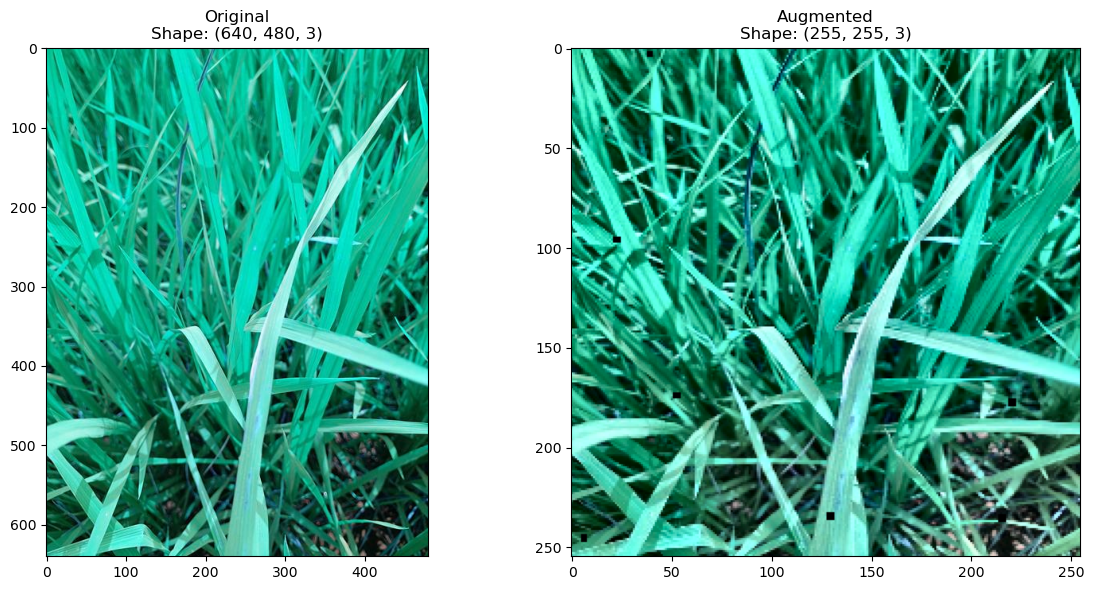

Generator output shape: (28, 255, 255, 3)
Model input shape: (None, 255, 255, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - accuracy: 0.1786 - loss: 1.8703 - val_accuracy: 0.2500 - val_loss: 1.7681 - learning_rate: 0.0010


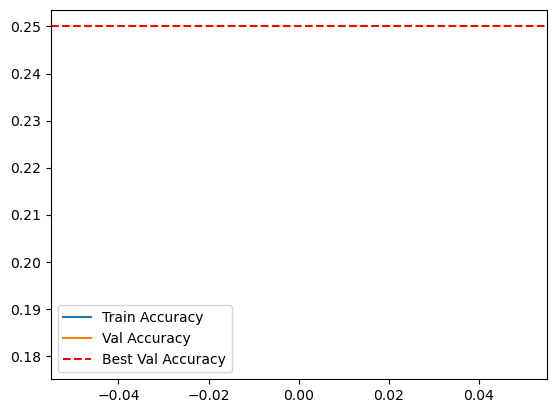

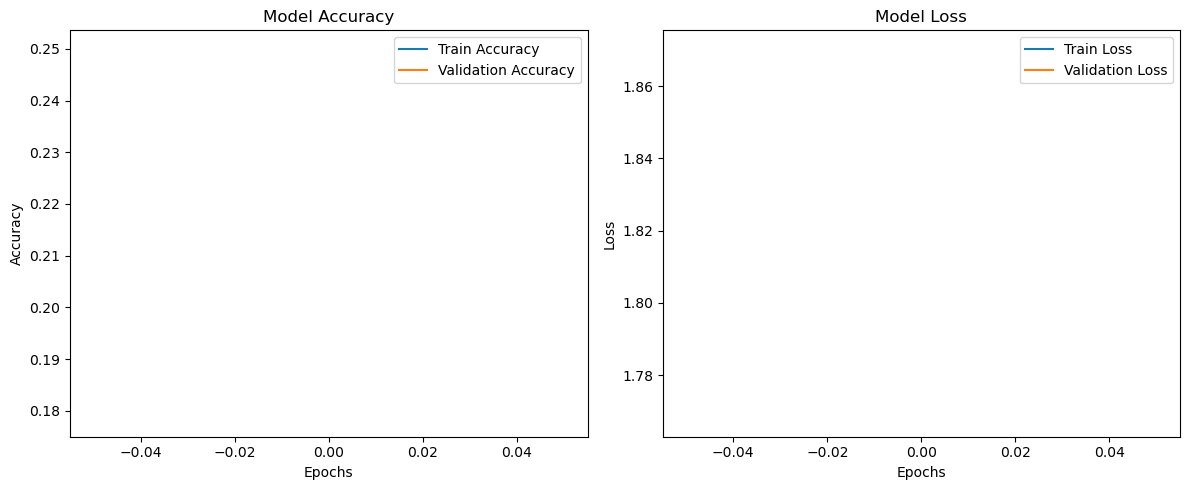

Evaluating on 8 samples

[DEBUG] First batch - X shape: (8, 255, 255, 3), y shape: (8,)
[DEBUG] Sample label: 4 -> dead_heart
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step - acc: 0.2500 - loss: 1.7623 - top3_acc: 0.6250

[METRICS] Evaluation Results: {'acc': 0.25, 'loss': 1.7622861862182617, 'top3_acc': 0.625}

[PREDICTION SAMPLES]
True: dead_heart (4) | Pred: blast (2)
True: downy_mildew (5) | Pred: blast (2)
True: bacterial_leaf_blight (0) | Pred: blast (2)
True: bacterial_panicle_blight (1) | Pred: blast (2)
True: blast (2) | Pred: blast (2)

[CONFUSION MATRIX PARAMETERS]
- Classes: ['bacterial_leaf_blight' 'bacterial_panicle_blight' 'blast' 'brown_spot'
 'dead_heart' 'downy_mildew']
- Total samples: 8
- Batch size: 200 (affects matrix granularity)
- Most confused classes: Will be visible in plot


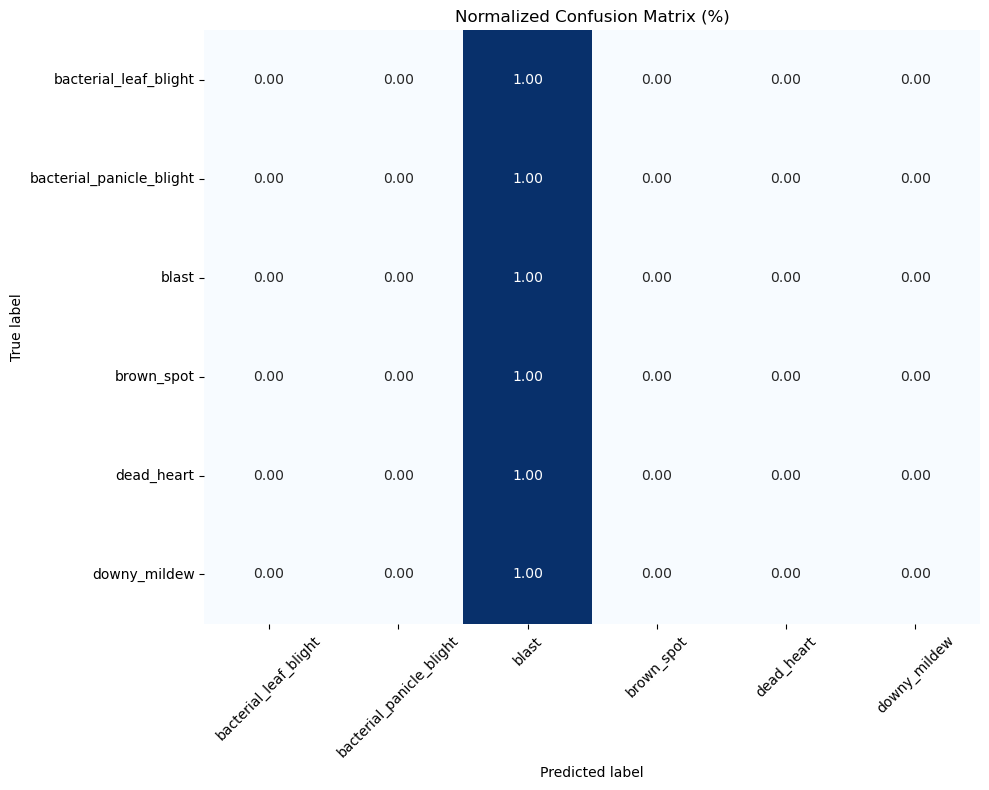

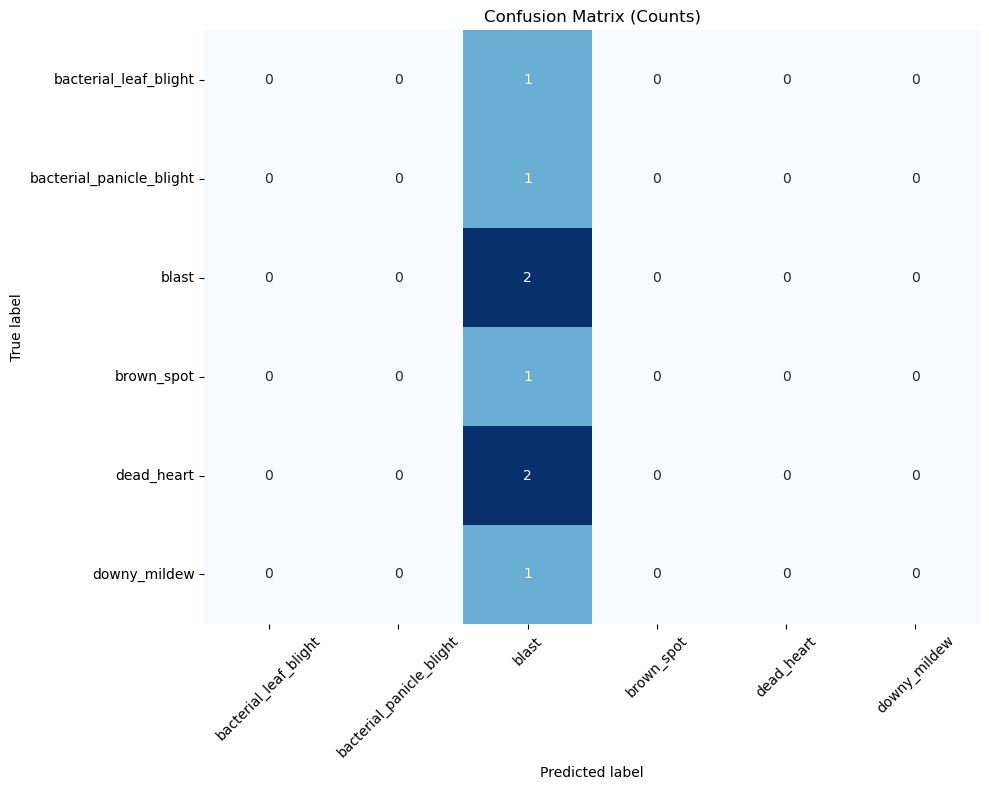


[CLASSIFICATION REPORT]
                          precision    recall  f1-score   support

   bacterial_leaf_blight       0.00      0.00      0.00         1
bacterial_panicle_blight       0.00      0.00      0.00         1
                   blast       0.25      1.00      0.40         2
              brown_spot       0.00      0.00      0.00         1
              dead_heart       0.00      0.00      0.00         2
            downy_mildew       0.00      0.00      0.00         1

                accuracy                           0.25         8
               macro avg       0.04      0.17      0.07         8
            weighted avg       0.06      0.25      0.10         8



/home/derrickle/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/derrickle/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/derrickle/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'acc': 0.25, 'loss': 1.7622861862182617, 'top3_acc': 0.625}

In [7]:
config_4 = {
    **config, 
    "target_size": (255, 255),
    "input_shape": (255, 255, 3),
    "augmentation": [
            A.Resize(width=255, height=255),
            A.HueSaturationValue(p=0.5),
            A.CLAHE(p=0.5),
            A.CoarseDropout(num_holes_range=[5, 10], hole_height_range=[0.01, 0.02], hole_width_range=[0.01, 0.02], max_holes=3, max_height=5, max_width=5), 
        ]
}
model_4, model_history_4 = train(config_4)

plot_accuracy_loss(model_history_4)

save_dir_4 = 'Model/training7_alex_incept_rgb_Attention_SMOT'
os.makedirs(save_dir_4, exist_ok=True)
model_path = os.path.join(save_dir_4, 'model_4.keras')
model_4.save(model_path)

history_path_4 = os.path.join(save_dir_4, 'model_history_4.pkl')
with open(history_path_4, 'wb') as f:
    pickle.dump(model_history_4.history, f)
    
evaluate_saved_model(use_val_set=True, config=config_4)

/tmp/ipykernel_397072/302744122.py:7: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(num_holes_range=[5, 10], hole_height_range=[0.01, 0.02], hole_width_range=[0.01, 0.02], max_holes=3, max_height=5, max_width=5),


Label classes: ['bacterial_leaf_blight' 'bacterial_panicle_blight' 'blast' 'brown_spot'
 'dead_heart' 'downy_mildew']
Classes:  6

=== Training Configuration ===
Batch size: 200
Input size: (255, 255)
Classes: 6
GPU Memory: 10GB

Model input shape: (None, 255, 255, 3)


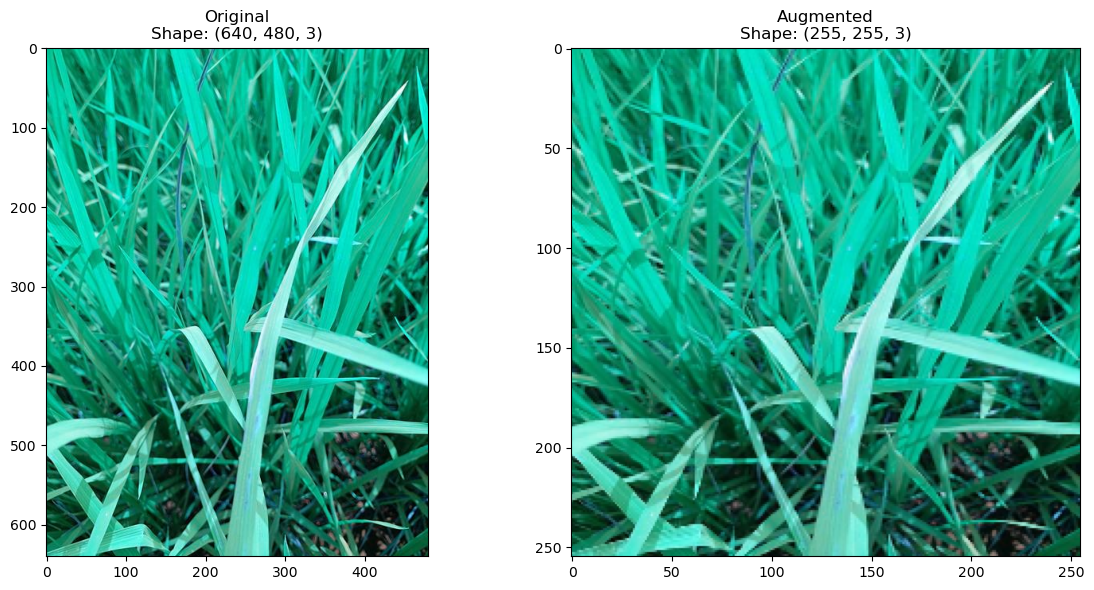

Generator output shape: (28, 255, 255, 3)
Model input shape: (None, 255, 255, 3)


In [ ]:
config_2 = {
    **config, 
    "target_size": (255, 255),
    "input_shape": (255, 255, 3),
    "augmentation": [
        A.Resize(width=255, height=255),
        A.CoarseDropout(num_holes_range=[5, 10], hole_height_range=[0.01, 0.02], hole_width_range=[0.01, 0.02], max_holes=3, max_height=5, max_width=5), 
    ]
}
model_2, model_history_2 = train(config_2)

save_dir_2 = 'Model/training7_alex_incept_rgb_Attention_SMOT'
os.makedirs(save_dir_2, exist_ok=True)
model_path = os.path.join(save_dir_2, 'model_2.keras')
model_2.save(model_path)

history_path_2 = os.path.join(save_dir_2, 'model_history_2.pkl')
with open(history_path_2, 'wb') as f:
    pickle.dump(model_history_2.history, f)